<a href="https://colab.research.google.com/github/mcbhavana27/ITS/blob/main/nas_CNN_LSTM_depthwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from keras.models import Sequential,Model
from keras.metrics import MeanSquaredError as mae
from keras.layers import LSTM,Dense,Dropout,Conv1D,TimeDistributed,Input,Flatten,Concatenate
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from math import sqrt
#from bokeh.plotting import figure,output_file, show
import datetime
from keras.callbacks import ModelCheckpoint
#from openpyxl import Workbook,load_workbook
from keras.layers import DepthwiseConv2D
from keras import layers


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp  /content/drive/My\ Drive/DATA.zip /content/
!unzip DATA.zip

Archive:  DATA.zip
   creating: DATA/
   creating: DATA/402214/
  inflating: DATA/402214/8.csv       
  inflating: DATA/402214/9.csv       
  inflating: DATA/402214/1.csv       
  inflating: DATA/402214/2.csv       
  inflating: DATA/402214/5.csv       
  inflating: DATA/402214/4.csv       
  inflating: DATA/402214/11.csv      
  inflating: DATA/402214/3.csv       
  inflating: DATA/402214/10.csv      
  inflating: DATA/402214/12.csv      
  inflating: DATA/402214/13.csv      
  inflating: DATA/402214/7.csv       
  inflating: DATA/402214/6.csv       
   creating: DATA/402510/
  inflating: DATA/402510/3.csv       
  inflating: DATA/402510/12.csv      
  inflating: DATA/402510/13.csv      
  inflating: DATA/402510/10.csv      
  inflating: DATA/402510/8.csv       
  inflating: DATA/402510/4.csv       
  inflating: DATA/402510/11.csv      
  inflating: DATA/402510/7.csv       
  inflating: DATA/402510/6.csv       
  inflating: DATA/402510/9.csv       
  inflating: DATA/402510/5.csv      

In [4]:
Data_file1= glob('DATA/402214'+'/*.csv')
Data_file2= glob('DATA/402510'+'/*.csv')
Data_file3= glob('DATA/402835'+'/*.csv')
Data_file4= glob('DATA/414025'+'/*.csv')

In [5]:
def data(files,col):
    data=[]
    for file in files:
          data.append(pd.read_csv(file))
    full_data =pd.concat(data,ignore_index=True)
    cols=list(full_data)[col]
    data_set=full_data[cols].astype(str)
    data_set = np.array(data_set)
    return data_set

In [6]:
Data1 = data(Data_file1,2)
Data2 = data(Data_file2,2)
Data3 = data(Data_file3,2)
Data4 = data(Data_file4,2)

In [7]:
data1 = Data1.reshape(Data1.shape[0],1)
scaler1 =MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler1.fit_transform(data1)

In [8]:
data_set = ([Data1,Data2,Data3,Data4])
max_len =max([len(data) for data in data_set ])

In [9]:
def fill_data(data):
    x=data
    l=len(x)
    y=x
    while l<max_len:
        y= np.insert(x,-1,x[-1])
        x=y
        l=len(x)
    return y
        

In [10]:
data1 =fill_data(Data1)
data2 = fill_data(Data2)
data3 = fill_data(Data3)
data4 = fill_data(Data4)
data_set = np.column_stack((data1,data2,data3,data4))

In [11]:
scaler =MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_set)

In [12]:
n_step = 21
Data =[]

for i in range(max_len-(n_step+1)):
    Data.append(data_scaled[i:i+n_step+1])

Data =np.array(Data)
#Data = Data.reshape(Data.shape[0],Data.shape[2],Data.shape[1])

In [13]:
Train = Data[:]
Train_Y=Train[:,-1,0]
Train_X = Train[:,:n_step]
Train_X1 =Train[:,:n_step,0]
Train_wd =Train[:,:n_step]

In [14]:
x=[]
x1=[]
x_w=[]
x_d=[]
y=[]
for i in range(len(Train)):
    if i >= 2016:
        x.append(Train_X[i])
        x_w.append(Train_X[i-2016])
        x_d.append(Train_X[i-288])
        x1.append(Train_X1[i])
        y.append(Train_Y[i])
x=np.array(x)
x1=np.array(x1)
x_w=np.array(x_w)
x_d=np.array(x_d)
y=np.array(y)      
y=y.reshape(y.shape[0],1)

In [15]:
x1.shape,x.shape

((24155, 21), (24155, 21, 4))

In [16]:
train_x=x[:-2016]
test_x=x[-2016:]
train_x1=x1[:-2016]
test_x1=x1[-2016:]
train_x_w=x_w[:-2016]
test_x_w=x_w[-2016:]
train_x_d=x_d[:-2016]
test_x_d=x_d[-2016:]
train_y=y[:-2016]
test_y=y[-2016:]


In [17]:
train_x1=train_x1.reshape(train_x1.shape[0],train_x1.shape[1],1)
test_x1=test_x1.reshape(test_x1.shape[0],test_x1.shape[1],1)

In [18]:
input1=Input(shape=(n_step,4),name ='input1')
input2=Input(shape=(n_step,1),name ='input2')
input3=Input(shape=(n_step,4),name ='input3')
input4=Input(shape=(n_step,4),name ='input4')
con1=tf.keras.layers.SeparableConv1D(30,3,padding='same',activation='relu',name='con1')(input1)
con2=tf.keras.layers.SeparableConv1D(30,3,padding='same',activation='relu',name='con2')(con1)
con3=tf.keras.layers.SeparableConv1D(20,2,padding='same',activation='relu',name='con3')(con2)
con_fl = Flatten()(con3)
lstm_out=LSTM(60,activation='relu',return_sequences=False,name='lstm_out')(input2)
lstm_out1=LSTM(30,activation='relu',return_sequences=True,name='lstm_out1')(input3)
lstm_out2=LSTM(30,activation='relu',return_sequences=False,name='lstm_out2')(lstm_out1)
lstm_out3=LSTM(30,activation='relu',return_sequences=True,name='lstm_out3')(input4)
lstm_out4=LSTM(30,activation='relu',return_sequences=False,name='lstm_out4')(lstm_out3)
x=Concatenate()([con_fl,lstm_out,lstm_out2,lstm_out4])
x1=Dense(20,activation='relu',name='x1')(x)
x2=Dense(10,activation='relu',name='x2')(x1)
output1 = Dense(1,activation='relu',kernel_regularizer=regularizers.l1(0.002),name='output1')(x2)
model=Model(inputs=[input1,input2,input3,input4],outputs=output1)
model.compile(optimizer='adam',loss='mse')

In [19]:
history=model.fit([train_x,train_x1,train_x_w,train_x_d],train_y,epochs=100,validation_split=.15,verbose=1)

Epoch 1/100
589/589 [==============================] - 29s 38ms/step - loss: 0.0130 - val_loss: 0.0077
Epoch 2/100
589/589 [==============================] - 22s 37ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 3/100
589/589 [==============================] - 22s 37ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 4/100
589/589 [==============================] - 23s 39ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 5/100
589/589 [==============================] - 21s 35ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 6/100
589/589 [==============================] - 22s 37ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 7/100
589/589 [==============================] - 22s 38ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 8/100
589/589 [==============================] - 21s 36ms/step - loss: 9.0400e-04 - val_loss: 0.0026
Epoch 9/100
589/589 [==============================] - 22s 37ms/step - loss: 7.8864e-04 - val_loss: 0.0018
Epoch 10/100
589/589 [==============================] - 21s 36ms/

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                                  
 con1 (SeparableConv1D)         (None, 21, 30)       162         ['input1[0][0]']                 
                                                                                                  
 con2 (SeparableConv1D)         (None, 21, 30)       1020        ['con1[0][0]']                   
                                                                                                  
 input3 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                              

In [21]:
model_json = model.to_json()
with open("depsepcnnlstmmodel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("cnn_lstm_sep.h5")

In [22]:
# to compute the weight of layers
# Get the weights of the model
weights = model.get_weights()

# Print the shape of each weight tensor
for weight in weights:
    print(weight.shape)



(3, 4, 1)
(1, 4, 30)
(30,)
(3, 30, 1)
(1, 30, 30)
(30,)
(2, 30, 1)
(1, 30, 20)
(20,)
(4, 120)
(30, 120)
(120,)
(4, 120)
(30, 120)
(120,)
(1, 240)
(60, 240)
(240,)
(30, 120)
(30, 120)
(120,)
(30, 120)
(30, 120)
(120,)
(540, 20)
(20,)
(20, 10)
(10,)
(10, 1)
(1,)


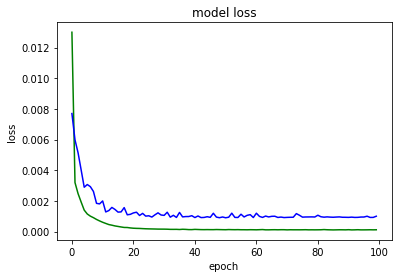

In [23]:
plt.plot(history.history["loss"],color='green')
plt.plot(history.history["val_loss"],color='blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [24]:
js = open("/content/depsepcnnlstmmodel.json")
lm = js.read()
js.close()
model1 = tf.keras.models.model_from_json(lm)

In [25]:
new_model=model1

new_model.load_weights("cnn_lstm_sep.h5")

In [26]:
y_predict_scaled = new_model.predict([test_x,test_x1,test_x_w,test_x_d])

63/63 [==============================] - 1s 10ms/step


In [27]:
y_predict=scaler1.inverse_transform(y_predict_scaled)

In [28]:
test_Y=scaler1.inverse_transform(test_y)

In [29]:
print(mae(y_predict,test_Y))

1.7253041726256177


In [30]:
print(sqrt(mse(y_predict,test_Y)))

2.26202665860943


In [31]:
print(mape(y_predict,test_Y))

0.02550131432695687


In [32]:
Error=[]
for i in range(len(test_Y)):
    Error.append(abs(y_predict[i]-test_Y[i]))

In [33]:

# js = open("/content/depsepcnnlstmmodel.json")
# lm = js.read()
# js.close()
# model1 = tf.keras.models.model_from_json(lm)
# new_model=model1
# new_model.load_weights("cnn_lstm_sep.h5")

NAS implementation

In [34]:
def count_mac_ops(model):
    total_mac_ops = 0
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D):
            mac_ops = layer.kernel_size[0] * layer.output_shape[1] * layer.filters * layer.input_shape[-1]
        elif isinstance(layer, layers.SeparableConv1D):
            mac_ops = layer.kernel_size[0] * layer.output_shape[1] * layer.depth_multiplier * layer.input_shape[-1] + layer.output_shape[1] * layer.filters
        elif isinstance(layer, layers.Conv2D):
            mac_ops = layer.kernel_size[0] * layer.kernel_size[1] * layer.output_shape[1] * layer.output_shape[2] * layer.filters * layer.input_shape[-1]
        elif isinstance(layer, layers.SeparableConv2D):
            mac_ops = (layer.kernel_size[0] * layer.kernel_size[1] * layer.input_shape[-1] * layer.depth_multiplier +
                      layer.output_shape[1] * layer.output_shape[2] * layer.filters)
        elif isinstance(layer, layers.Dense):
            mac_ops = layer.input_shape[-1] * layer.output_shape[-1]
        elif isinstance(layer, layers.LSTM) or isinstance(layer, layers.GRU):
            mac_ops = 4 * (layer.input_shape[-1] * layer.units + layer.units**2)
        elif isinstance(layer, layers.Bidirectional):
            forward_layer = layer.forward_layer
            backward_layer = layer.backward_layer
            forward_mac_ops = 4 * (layer.input_shape[-1] * forward_layer.units + forward_layer.units**2)
            backward_mac_ops = 4 * (layer.input_shape[-1] * backward_layer.units + backward_layer.units**2)
            mac_ops = 2 * (forward_mac_ops + backward_mac_ops)
        else:
            mac_ops = 0
        total_mac_ops += mac_ops
    return total_mac_ops

In [35]:
count_mac_ops(new_model)

53292

In [36]:
input1=Input(shape=(n_step,4),name ='input1')
input2=Input(shape=(n_step,1),name ='input2')
input3=Input(shape=(n_step,4),name ='input3')
input4=Input(shape=(n_step,4),name ='input4')
con1=Conv1D(30,3,padding='same',activation='relu',name='con1')(input1)
con2=Conv1D(30,3,padding='same',activation='relu',name='con2')(con1)
con3=Conv1D(20,2,padding='same',activation='relu',name='con3')(con2)
con_fl = Flatten()(con3)
lstm_out=LSTM(60,activation='relu',return_sequences=False,name='lstm_out')(input2)
lstm_out1=LSTM(30,activation='relu',return_sequences=True,name='lstm_out1')(input3)
lstm_out2=LSTM(30,activation='relu',return_sequences=False,name='lstm_out2')(lstm_out1)
lstm_out3=LSTM(30,activation='relu',return_sequences=True,name='lstm_out3')(input4)
lstm_out4=LSTM(30,activation='relu',return_sequences=False,name='lstm_out4')(lstm_out3)
x=Concatenate()([con_fl,lstm_out,lstm_out2,lstm_out4])
x1=Dense(20,activation='relu',name='x1')(x)
x2=Dense(10,activation='relu',name='x2')(x1)
output1 = Dense(1,activation='relu',kernel_regularizer=regularizers.l1(0.002),name='output1')(x2)
model2=Model(inputs=[input1,input2,input3,input4],outputs=output1)
model2.compile(optimizer='adam',loss='mse')

In [37]:
count_mac_ops(model2)

137670

In [38]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [50]:
width_multipliers = [0.2, 0.4, 0.7, 0.8, 0.9, 1.0]
min_depth = 2
max_depth = 9
threshold_mac_ops =  30000 # threshold for the maximum number of MAC operations
target_loss = 0.04 # target validation loss for stopping the model training
fail_loss = 0.04 # validation loss for discarding the model

In [51]:
feasible_models =[]
for width in width_multipliers:
  for depth in range(2,9):
    input1=Input(shape=(n_step,4),name ='input1')
    input2=Input(shape=(n_step,1),name ='input2')
    input3=Input(shape=(n_step,4),name ='input3')
    input4=Input(shape=(n_step,4),name ='input4')
    con1=tf.keras.layers.SeparableConv1D(int(30 * width),3,padding='same',activation='relu',name='con1')(input1)
    y=tf.keras.layers.SeparableConv1D(int(30 * width),3,padding='same',activation='relu',name='con2')(con1)
    for i in range(depth-1):
      y=tf.keras.layers.SeparableConv1D(int(20 * width),2,padding='same',activation='relu')(y)
    con_fl = Flatten()(y)
    lstm_out=LSTM(int(60 * width),activation='relu',return_sequences=False,name='lstm_out')(input2)
    lstm_out1=LSTM(int(30 * width),activation='relu',return_sequences=True,name='lstm_out1')(input3)
    lstm_out2=LSTM(int(30 * width),activation='relu',return_sequences=False,name='lstm_out2')(lstm_out1)
    lstm_out3=LSTM(int(30 * width),activation='relu',return_sequences=True,name='lstm_out3')(input4)
    lstm_out4=LSTM(int(30 * width),activation='relu',return_sequences=False,name='lstm_out4')(lstm_out3)
    x=Concatenate()([con_fl,lstm_out,lstm_out2,lstm_out4])
    x1=Dense(int(20 * width),activation='relu',name='x1')(x)
    x2=Dense(int(10 * width),activation='relu',name='x2')(x1)
    output1 = Dense(1,activation='relu',kernel_regularizer=regularizers.l1(0.002),name='output1')(x2)
    modeln=Model(inputs=[input1,input2,input3,input4],outputs=output1)
    modeln.compile(optimizer='adam',loss='mse')
    maco = count_mac_ops(modeln)
    print(maco)
    if(maco < threshold_mac_ops):
      feasible_models.append(modeln)



3340
3592
3844
4096
4348
4600
4852
10188
10692
11196
11700
12204
12708
13212
27510
28392
29274
30156
31038
31920
32802
35164
36172
37180
38188
39196
40204
41212
43758
44892
46026
47160
48294
49428
50562
53292
54552
55812
57072
58332
59592
60852


In [52]:
print(len(feasible_models))

17


In [54]:
best_models=[]
for modeli in feasible_models:
  modeli.summary()
  historyi = modeli.fit([train_x,train_x1,train_x_w,train_x_d],train_y,epochs=3,validation_split=.15,verbose=1)
  yps= modeli.predict([test_x,test_x1,test_x_w,test_x_d])
  yp=scaler1.inverse_transform(y_predict_scaled)
  # yps = modeli.predict([test_x,test_x_w,test_x_d])
  # yp=scaler1.inverse_transform(yps )
  maee = mae(yp,test_Y)
  msee=sqrt(mse(yp,test_Y))
  mapee=mape(yp,test_Y)
  print("mae",maee)
  print("mse",msee)
  print("mape",mapee)
  print("\n")
  if(maee <2.0 and msee<2.5 and mapee<0.03):
    best_models.append(modeli)

Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                                  
 con1 (SeparableConv1D)         (None, 21, 6)        42          ['input1[0][0]']                 
                                                                                                  
 con2 (SeparableConv1D)         (None, 21, 6)        60          ['con1[0][0]']                   
                                                                                                  
 input3 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                           

In [43]:
print(len(best_models))

42


In [59]:
c=0
for modeli in best_models:
  historyi = modeli.fit([train_x,train_x1,train_x_w,train_x_d],train_y,epochs=10,validation_split=.15,verbose=1)
  yps= modeli.predict([test_x,test_x1,test_x_w,test_x_d])
  yp=scaler1.inverse_transform(yps)
  maee = mae(yp,test_Y)
  msee=sqrt(mse(yp,test_Y))
  mapee=mape(yp,test_Y)
  print("model :" ,c)
  print("mae",maee)
  print("mse",msee)
  print("mape",mapee)
  print("\n")

  model_json = modeli.to_json()
  with open("depsepcnnlstmmodel-"+str(c)+".json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights("cnn_lstm_sep-"+str(c)+".h5")

  c+=1

Epoch 1/10
589/589 [==============================] - 20s 33ms/step - loss: 1.6245e-04 - val_loss: 8.3845e-04
Epoch 2/10
589/589 [==============================] - 19s 32ms/step - loss: 1.6265e-04 - val_loss: 8.7880e-04
Epoch 3/10
589/589 [==============================] - 20s 33ms/step - loss: 1.5967e-04 - val_loss: 8.3624e-04
Epoch 4/10
589/589 [==============================] - 18s 31ms/step - loss: 1.6552e-04 - val_loss: 8.3778e-04
Epoch 5/10
589/589 [==============================] - 21s 35ms/step - loss: 1.6415e-04 - val_loss: 9.1480e-04
Epoch 6/10
589/589 [==============================] - 19s 31ms/step - loss: 1.6271e-04 - val_loss: 8.3915e-04
Epoch 7/10
589/589 [==============================] - 19s 33ms/step - loss: 1.6037e-04 - val_loss: 8.3488e-04
Epoch 8/10
589/589 [==============================] - 18s 31ms/step - loss: 1.6445e-04 - val_loss: 8.5842e-04
Epoch 9/10
589/589 [==============================] - 19s 32ms/step - loss: 1.6712e-04 - val_loss: 8.9159e-04
Epoch 10/1

In [60]:
best_models[1].summary()

Model: "model_87"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                                  
 con1 (SeparableConv1D)         (None, 21, 6)        42          ['input1[0][0]']                 
                                                                                                  
 con2 (SeparableConv1D)         (None, 21, 6)        60          ['con1[0][0]']                   
                                                                                                  
 separable_conv1d_337 (Separabl  (None, 21, 4)       40          ['con2[0][0]']                   
 eConv1D)                                                                                  

In [61]:
# tf lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]



# def representative_dataset_generator():
#   for value in X_test:
#     # Each scalar value must be inside of a 2D array that is wrapped in a list
#     print(value)
#     yield [np.array(value, dtype=np.float32, ndmin=2)]
# converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()

# Save the model to disk
open("cnn_lstm_model_quantized.tflite", "wb").write(tflite_model)

107792

In [62]:

tf_modelq = tf.lite.Interpreter('cnn_lstm_model_quantized.tflite')
tf_modelq.allocate_tensors()
input_details = tf_modelq.get_input_details()
output_details = tf_modelq.get_output_details()
tf_modelq_predictions = []
input_shape = input_details[0]['shape']
input_shape1 = input_details[1]['shape']
input_shape2 = input_details[2]['shape']
input_shape3 = input_details[3]['shape']
input_data = np.array(test_x, dtype=np.float32)
input_data1 = np.array(test_x1, dtype=np.float32)
input_data2 = np.array(test_x_w, dtype=np.float32)
input_data3 = np.array(test_x_d, dtype=np.float32)
tf_model_output_index = output_details[0]['index']
for i in range(len(test_x1)):
    tf_modelq.set_tensor(input_details[0]['index'], input_data2[i].reshape(1,input_data2.shape[1],input_data2.shape[2]))
    tf_modelq.set_tensor(input_details[1]['index'], input_data[i].reshape(1,input_data.shape[1],input_data.shape[2]))
    tf_modelq.set_tensor(input_details[2]['index'], input_data3[i].reshape(1,input_data3.shape[1],input_data3.shape[2]))
    tf_modelq.set_tensor(input_details[3]['index'], input_data1[i].reshape(1,input_data1.shape[1],input_data1.shape[2]))
    
    tf_modelq.invoke()
    x1=tf_modelq.get_tensor(tf_model_output_index)
    tf_modelq_predictions.append(x1[0])

In [63]:
# Get the weights of the model
# weights = tf_modelq.get_weights()

# Load the model into the interpreter
interpreter = tf.lite.Interpreter(model_path="cnn_lstm_model_quantized.tflite")
interpreter.allocate_tensors()

# Get the weights for the first layer
weights_tensor_index = interpreter.get_input_details()[0]["index"]
weights = interpreter.get_tensor(weights_tensor_index)

print(weights.shape)


(1, 21, 4)


In [64]:
tf_pred=scaler1.inverse_transform(tf_modelq_predictions)

In [65]:
print(mae(tf_pred,test_Y))

1.7383208041086737


In [66]:
print(sqrt(mse(tf_pred,test_Y)))

2.257742550682925


In [67]:
print(mape(tf_pred,test_Y))

0.026931615586763276
